In [95]:
import pandas as pd
from statsmodels.formula.api import ols
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [96]:
data = pd.read_csv('forms.csv').loc[:, 'perguntar para o entrevistador:':]

In [97]:
data.columns = ['tipo', 'animais', 'n_cervos', 'macaco', 'urso', 'cobra', 'dia_noite', 'sol', 'trilha', 'arvore', 'casa']

In [98]:
respostas_certas_demo = {
    'n_cervos': '3',
    'macaco': 'Não havia macaco no trajeto',
    'urso': 'Dormindo',
    'cobra': 'Não havia cobra no trajeto',
    'dia_noite': 'Dia',
    'sol': 'Sim',
    'trilha': 'Terra',
    'arvore': 'Pinheiro',
    'casa': 'Vermelha'
}

In [99]:
respostas_certas_video = {
    'n_cervos': '3',
    'macaco': 'Não havia macaco no trajeto',
    'urso': 'Dormindo',
    'cobra': 'Não havia cobra no trajeto',
    'dia_noite': 'Dia',
    'sol': 'Não',
    'trilha': 'Terra',
    'arvore': 'Pinheiro',
    'casa': 'Vermelha'
}

In [100]:
def encode_df(df):
    parsed = df.copy()
    for i in range(len(parsed)):
        if parsed.loc[i, 'tipo'] == 'demo':
            respostas = respostas_certas_demo
        else:
            respostas = respostas_certas_video  

        for key, value in respostas.items():
            if parsed.loc[i, key] == value:
                parsed.loc[i, key] = 1
            elif parsed.loc[i, key] == 'Não sei':
                parsed.loc[i, key] = 0
            else:
                parsed.loc[i, key] = 0

        if all(animal in parsed.loc[i, 'animais'] for animal in ['Cervo', 'Urso', 'Passarinho']) \
            and len(parsed.loc[i, 'animais'].split(',')) == 3:
                parsed.loc[i, 'animais'] = 1
        else:
            parsed.loc[i, 'animais'] = 0
    
    for col in parsed.columns[1:]:
        parsed[col] = pd.to_numeric(parsed[col])

    respostas = [*parsed.animais, 
             *parsed.n_cervos,
             *parsed.macaco,
             *parsed.urso,
             *parsed.cobra,
             *parsed.dia_noite,
             *parsed.sol,
             *parsed.trilha,
             *parsed.arvore,
             *parsed.casa]
    
    return pd.DataFrame({'respostas': respostas, 'tipo': [*parsed.tipo] * 10})

In [101]:
def encode_df_2(df):
    parsed = df.copy()
    for i in range(len(parsed)):
        if parsed.loc[i, 'tipo'] == 'demo':
            respostas = respostas_certas_demo
        else:
            respostas = respostas_certas_video  

        for key, value in respostas.items():
            if parsed.loc[i, key] == value:
                parsed.loc[i, key] = 2
            elif parsed.loc[i, key] == 'Não sei':
                parsed.loc[i, key] = 1
            else:
                parsed.loc[i, key] = 0

        if all(animal in parsed.loc[i, 'animais'] for animal in ['Cervo', 'Urso', 'Passarinho']) \
            and len(parsed.loc[i, 'animais'].split(',')) == 3:
                parsed.loc[i, 'animais'] = 2
        elif any(animal in parsed.loc[i, 'animais'] for animal in ['Cervo', 'Urso', 'Passarinho']):
            parsed.loc[i, 'animais'] = 1
        else:
            parsed.loc[i, 'animais'] = 0
    
    for col in parsed.columns[1:]:
        parsed[col] = pd.to_numeric(parsed[col])

    respostas = [*parsed.animais, 
             *parsed.n_cervos,
             *parsed.macaco,
             *parsed.urso,
             *parsed.cobra,
             *parsed.dia_noite,
             *parsed.sol,
             *parsed.trilha,
             *parsed.arvore,
             *parsed.casa]
    
    return pd.DataFrame({'respostas': respostas, 'tipo': [*parsed.tipo] * 10})

In [102]:
model = ols('''respostas~ C(tipo, Sum)''', data=encode_df_2(data)).fit()

In [103]:
aov_table = sm.stats.anova_lm(model, typ=3)
print(aov_table)

                   sum_sq     df            F         PR(>F)
Intercept     1141.686261    1.0  2092.433825  1.903770e-180
C(tipo, Sum)     1.206261    1.0     2.210783   1.376819e-01
Residual       271.721739  498.0          NaN            NaN


In [104]:
sns.set_theme(style="darkgrid")

In [105]:
video = encode_df_2(data)[encode_df_2(data)['tipo'] == 'Vídeo'].sort_values(by='respostas')
video['answers'] = video['respostas'].replace({0: 'Wrong', 1: 'DoNotKnow', 2: 'Right'})

demo = encode_df_2(data)[encode_df_2(data)['tipo'] == 'Demo'].sort_values(by='respostas')
demo['answers'] = demo['respostas'].replace({0: 'Wrong', 1: 'DoNotKnow', 2: 'Right'})

(0.0, 1.0)

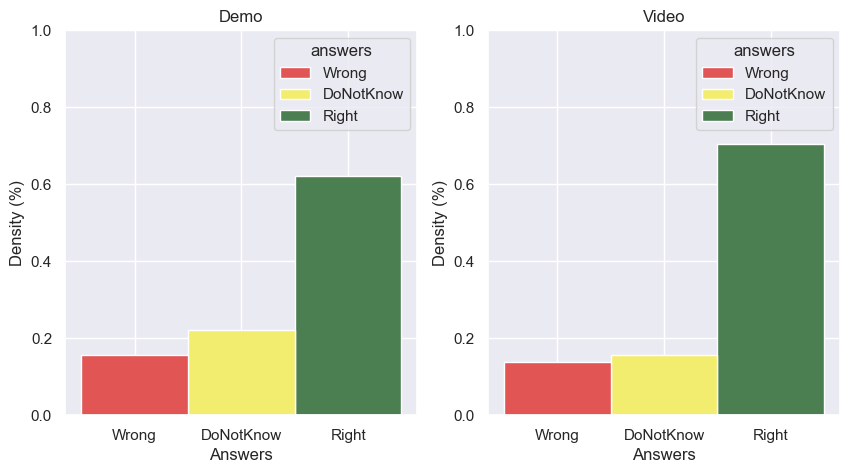

In [107]:
# create two graphs side by side showing the relative frequency of each value in the respostas column filtered by tipo
# make both graphs with the same colors
# make both graphs with the same y axis scale

palette = {'Wrong': '#E15554', 'DoNotKnow': '#F2ED6F', 'Right': '#4B7F52'}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(data=demo, x='answers', hue='answers', palette=palette, stat='probability', ax=ax1, alpha=1)

ax1.set_title('Demo')
ax1.set_xlabel('Answers')
ax1.set_ylabel('Density (%)')
ax1.set_ylim(0, 1)

sns.histplot(data=video, x='answers', hue='answers', palette=palette, stat='probability', ax=ax2, alpha=1)

ax2.set_title('Video')
ax2.set_xlabel('Answers')
ax2.set_ylabel('Density (%)')
ax2.set_ylim(0, 1)